In [19]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from collections import Counter

# BoTorch / GPyTorch 関連
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from mpl_toolkits.mplot3d import Axes3D  # 必要に応じて

# Plot周りの設定
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
plt.rcParams["figure.dpi"] = 100  # 高解像度設定

In [20]:
def styblinski_tang(x, noise_std=0.00001):
    """
    x: shape (..., d) のテンソル（d>=5を仮定）
       目的関数の計算には最初の5次元のみを利用する。
    noise_std: ノイズの標準偏差
    """
    if torch.is_tensor(x):
        x_val = x[..., :5]  # shape (..., 5)
    else:
        x_val = torch.tensor(x[..., :5], dtype=torch.float32)
    result = 0.5 * torch.sum(x_val ** 4 - 16 * x_val ** 2 + 5 * x_val, dim=-1)
    noise = torch.randn_like(result) * noise_std
    return result + noise

In [21]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, coordinate_ratio=0.5):
        """
        X: 初期サンプル点 (n_initial, dim)
        objective_function: 目的関数 (styblinski_tang など)
        bounds: 探索の下限・上限 (2, dim) のテンソル
        n_initial: 初期サンプル数
        n_max: 反復最大回数
        dim: 入力次元 (ここでは例として100)
        """
        dtype = torch.float
        self.num_arms = dim  # 各イテレーションで生成される候補方向の数

        # 線形バンディット用のパラメータ A, b の初期化
        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)

        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []        # 各反復でのbest_valueの履歴
        self.arm_selection_history = []  # 選択された arm のインデックスの履歴
        self.optimization_history = []   # 探索した新しい点の履歴
        self.saved_plot_files = []       # GP後方分布のプロット保存用

        self.coordinate_ratio = coordinate_ratio

        # ★追加★: UCBおよび線形バンディットの解析用パラメータ
        # 【Abbasi‐Yadkori et al. (2012)】に基づく設定例
        self.sigma = 0.1         # ノイズ標準偏差の仮定
        self.L = 5.0             # 各アーム（特徴ベクトル）のノルム上限
        self.lambda_reg = 1.0    # 正則化パラメータ
        self.delta = 0.1         # 失敗確率
        self.S = 10.0            # 真のパラメータのノルム上限

        # ★追加★: 選択された方向（実際のベクトル）と推定θの履歴を記録
        self.selected_direction_history = []  # 各イテレーションで選ばれた方向のベクトル
        self.theta_history = []                 # 各イテレーションでの推定パラメータ theta

        self.reward_history = []   # 各イテレーションの更新量（報酬）を記録
        self.iteration_table_data = []

        # ★変更★: 選択された方向の絶対値を累積（後で棒グラフで可視化）
        self.direction_sum_abs = torch.zeros(dim, dtype=dtype)

    def update_model(self):
        """
        BoTorchのSingleTaskGPを更新する。
        """
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-2).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        """
        初期点 X に対して目的関数を評価し、GPモデルを初期化する。
        GPの事後平均を用いて best_value と best_point を更新する。
        """
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)

        # GPモデル更新
        self.update_model()
        # GPの事後平均から最小値（最良の候補）を選ぶ
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]

        self.eval_history = [self.best_value] * self.n_initial

    def generate_arms(self):
        """
        1イテレーションにつき合計 self.num_arms(=dim) 本の候補方向ベクトルを生成する関数。
        - うち (coordinate_ratio * dim) 本は座標方向ベクトル
        - うち 残りはランダム方向ベクトル
        - 最後に v[0]<0 なら符号反転
        - 結果を (num_arms, dim) の torch.Tensor で返す
        """
        dtype = torch.float
        num_coord = int(math.floor(self.coordinate_ratio * self.dim))
        # 上限をdim以内に収める
        if num_coord > self.dim:
            num_coord = self.dim

        #-------------------------------------------
        # (1) 座標方向ベクトル: num_coord 本
        #-------------------------------------------
        #   ランダムに num_coord 個の次元を選び、その標準基底を作る
        random_indices = np.random.choice(self.dim, num_coord, replace=False)
        coordinate_arms = []
        for idx in random_indices:
            e_i = torch.zeros(self.dim, dtype=dtype)
            e_i[idx] = 1.0
            coordinate_arms.append(e_i)
        if len(coordinate_arms) > 0:
            coordinate_arms = torch.stack(coordinate_arms, dim=0)
        else:
            coordinate_arms = torch.zeros(0, self.dim, dtype=dtype)

        #-------------------------------------------
        # (2) ランダム方向ベクトル: 残り
        #-------------------------------------------
        num_random = self.dim - num_coord
        if num_random > 0:
            random_arms = torch.randn(num_random, self.dim, dtype=dtype)
            random_arms = random_arms / random_arms.norm(dim=1, keepdim=True)
        else:
            random_arms = torch.zeros(0, self.dim, dtype=dtype)

        #-------------------------------------------
        # (3) 結合
        #-------------------------------------------
        arms = torch.cat([coordinate_arms, random_arms], dim=0)

        return arms



    def select_arm(self, total_iterations):
        """
        線形バンディット（LinUCBに基づく）により、候補方向の中から最良と思われる方向を選択する。
        UCB値は以下の形で計算する：
            UCB(x) = x^T * theta + beta_t * sqrt(x^T * A^{-1} * x)
        ここで、beta_t は
            beta_t = sigma * sqrt(dim * log((1 + total_iterations * L^2 / lambda_reg) / delta)) + sqrt(lambda_reg) * S
        と定式化する（【Abbasi‐Yadkori et al. (2012)】参照）。
        また、現在の推定パラメータ theta を記録します。
        """
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        # 計算した theta を履歴に記録
        self.theta_history.append(theta.clone())

        p_values = []

        beta_t = self.sigma * math.sqrt(self.dim * math.log((1 + total_iterations * (self.L ** 2) / self.lambda_reg) / self.delta)) + math.sqrt(self.lambda_reg) * self.S

        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)  # shape (dim,1)
            mean = (theta.view(1, -1) @ x_arm).item()   # 推定期待報酬
            var = (x_arm.t() @ A_inv @ x_arm).item()      # 不確実性（分散）
            # UCBの計算
            ucb = mean + beta_t * math.sqrt(var)
            p_values.append(ucb)

        # 選ばれた arm のインデックスを返す
        return int(np.argmax(p_values))

    # ★ 新たにベイズ最適化部分を切り出したメソッド propose_new_x を追加
    def propose_new_x(self, direction):
        """
        GPモデルとEI (Expected Improvement) を用いて、現在の best_point から選択された方向 direction に沿った
        1次元の最適化を行い、bounds 内に収まる新たな評価点 new_x を返す関数です。

        戻り値:
            new_x: 新たに提案された評価点 (dim 次元のベクトル)
            candidate: optimize_acqf によって得られたスカラー候補 (torch.Tensor)
            acq_value: 対応するacquisition value
        """
        dtype = torch.float
        # EIの定義（現在の best_value を用いる）
        ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

        # 1次元最適化のための補助関数：best_point から direction に沿って t を変化させた点での EI を計算
        def eci_func(x):
            x_scalar = x.squeeze(-1).squeeze(-1)
            full_x = self.best_point.clone().unsqueeze(0) + x_scalar[:, None] * direction
            full_x = full_x.unsqueeze(1)
            return ei(full_x)

        # new_x = best_point + t * direction が各次元の bounds 内に収まるよう t の許容範囲を計算
        lower_list = []
        upper_list = []
        for i in range(self.dim):
            d_i = direction[i].item()
            if abs(d_i) < 1e-8:
                continue
            if d_i > 0:
                lower_list.append((self.bounds[0][i] - self.best_point[i]).item() / d_i)
                upper_list.append((self.bounds[1][i] - self.best_point[i]).item() / d_i)
            else:
                lower_list.append((self.bounds[1][i] - self.best_point[i]).item() / d_i)
                upper_list.append((self.bounds[0][i] - self.best_point[i]).item() / d_i)
        if lower_list:
            candidate_lower_bound = max(lower_list)
            candidate_upper_bound = min(upper_list)
            # 修正：もし下限が上限を超えている場合は、探索できないので t=0 を選ぶ
            if candidate_lower_bound > candidate_upper_bound:
                candidate_lower_bound = candidate_upper_bound = 0.0
        else:
            candidate_lower_bound = -5.0
            candidate_upper_bound = 5.0

        one_d_bounds = torch.tensor([[candidate_lower_bound], [candidate_upper_bound]], dtype=dtype)

        candidate, acq_value = optimize_acqf(
            eci_func,
            one_d_bounds,
            q=1,
            num_restarts=10,
            raw_samples=100,
        )

        new_x = self.best_point.clone() + candidate.squeeze() * direction
        return new_x, candidate, acq_value

    def optimize(self):
        """
        メインの最適化ループ。
        GPによる局所探索と線形バンディットによるグローバル探索（方向選択）を組み合わせる。
        各イテレーションで、推定パラメータ(theta)および選択した方向ベクトルを記録します。
        """
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        self.update_model()

        while n < self.n_max:
            self.arms_features = self.generate_arms()

            # 線形バンディットで候補方向を選択
            selected_arm = self.select_arm(total_iterations)
            self.arm_selection_history.append(selected_arm)
            direction = self.arms_features[selected_arm]
            # 記録：選択された方向ベクトルを保存
            self.selected_direction_history.append(direction.clone())

            # ★ ベイズ最適化部分を propose_new_x メソッドで実行し new_x を獲得する
            new_x, candidate, acq_value = self.propose_new_x(direction)

            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)

            # データの更新
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.optimization_history.append(new_x.clone())

            # 線形バンディットの情報更新：Aは方向ベクトルの外積で更新
            x_arm = direction.view(-1, 1)
            self.A = self.A + x_arm @ x_arm.t()

            # 現在の GP モデルを用いて new_x における事後平均を計算（p とする）
            p = self.model.posterior(new_x.unsqueeze(0)).mean.squeeze()
            # 報酬を exp(-||p - new_y||) で定義（ここでは p, new_y はスカラーと仮定）
            reward = 1 + - torch.exp(-torch.abs(p - new_y.squeeze())).item()
            self.reward_history.append(reward)
            self.b = self.b + reward * direction

            # GPモデルを更新し、GP事後平均の最小値で best_value, best_point を更新する
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index]

            self.eval_history.append(self.best_value)
            self.direction_sum_abs += direction.abs()

            # ★追加★: 各イテレーションの情報を記録する
            # まず、GPモデルのカーネルパラメータ（ここでは ScaleKernel 内の RBFKernel の lengthscale と outputscale）を取得
            kernel = self.model.covar_module
            # RBFKernel の lengthscale を取得（※場合によって shape が異なる場合があります）
            lengthscale = kernel.base_kernel.lengthscale.detach().cpu().numpy()
            outputscale = kernel.outputscale.detach().cpu().numpy()

            iteration_data = {
                "iteration": total_iterations,
                "x": new_x.detach().cpu().numpy(),       # このイテレーションで評価した x の値
                "y": new_y.item(),                         # 対応する目的関数値
                "best_value": self.best_value,             # GP事後平均による最良値
                "candidate_parameta": candidate.squeeze(), # EIによる最適化で選ばれたパラメータ
                "kernel_lengthscale": lengthscale,         # カーネルの lengthscale パラメータ
                "kernel_outputscale": outputscale,         # カーネルの outputscale パラメータ
                "reward": reward,                          # 更新時の reward（対数変換済み）
            }
            self.iteration_table_data.append(iteration_data)

            n += 1
            total_iterations += 1

        return self.best_point, self.best_value

In [22]:
class REMBO_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, d_emb=5):
        """
        d_emb: 埋め込み次元
        """
        dtype = torch.float
        self.objective_function = objective_function
        self.full_dim = dim
        self.d_emb = d_emb
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        # REMBOでは高次元空間から低次元へ射影するランダム行列Aを生成
        self.A = torch.randn(dim, d_emb, dtype=dtype)
        # 高次元上での評価データ
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def project(self, z):
        # 低次元変数 z (shape: (..., d_emb)) を高次元に射影: x = A z
        x = z @ self.A.t()
        # boundsに合わせてクリップ
        x = torch.clamp(x, self.bounds[0], self.bounds[1])
        return x

    def update_model(self, Z, Y):
        # 低次元上でのGPモデルを更新
        kernel = ScaleKernel(RBFKernel(ard_num_dims=Z.shape[-1]), noise_constraint=1e-5).to(Z)
        self.model = SingleTaskGP(Z, Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        # REMBOの初期点: 低次元上で一様サンプル
        Z_init = torch.rand(self.n_initial, self.d_emb) * 10 - 5  # [-5,5]の範囲
        X_init = self.project(Z_init)
        y_val = self.objective_function(X_init)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.Z = Z_init
        self.X = X_init
        self.update_model(self.Z, self.Y)
        posterior_mean = self.model.posterior(self.Z).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.project(self.Z[best_index].unsqueeze(0)).squeeze(0)
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            # 獲得関数 EI を低次元上で定義
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
            bounds_z = torch.tensor([[-5.0]] * self.d_emb + [[5.0]] * self.d_emb, dtype=dtype)
            bounds_tensor = torch.tensor([[-5.0] * self.d_emb, [5.0] * self.d_emb], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                ei,
                bounds=bounds_tensor,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            # 低次元候補から高次元点に射影
            new_z = candidate.squeeze()
            new_x = self.project(new_z.unsqueeze(0)).squeeze(0)
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            # データ更新（低次元・高次元共に）
            self.Z = torch.cat([self.Z, new_z.unsqueeze(0)])
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model(self.Z, self.Y)
            posterior_mean = self.model.posterior(self.Z).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.project(self.Z[best_index].unsqueeze(0)).squeeze(0)
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value


In [23]:
class Dropout_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, dropout_rate=0.5):
        """
        dropout_rate: 最適化で動かす次元の割合 (例: 0.5なら半分の次元)
        """
        dtype = torch.float
        self.objective_function = objective_function
        self.full_dim = dim
        self.dropout_rate = dropout_rate
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            num_vars = int((1 - self.dropout_rate) * self.full_dim)
            # numpy 配列から torch のインデックスに変換
            selected_dims_np = np.sort(np.random.choice(self.full_dim, num_vars, replace=False))
            selected_dims = torch.tensor(selected_dims_np, dtype=torch.long, device=self.X.device)
            def dropout_ei(x):
                # x: shape (batch_size, 1) または (batch_size, 1, 1)
                x_scalar = x.squeeze(-1).squeeze(-1)  # shape: (batch_size,)
                # self.best_point を detach して再利用しないようにする
                best_point = self.best_point.clone().detach()  # shape: (full_dim,)
                full_x = best_point.unsqueeze(0).expand(x_scalar.shape[0], -1)  # shape: (batch_size, full_dim)
                full_x[:, selected_dims] = full_x[:, selected_dims] + x_scalar.unsqueeze(1)
                # ExpectedImprovement の入力は [batch_size, q, d] (ここで q=1)
                full_x = full_x.unsqueeze(1)  # shape: (batch_size, 1, full_dim)
                ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
                return ei(full_x)
            one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                dropout_ei,
                one_d_bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            new_x = self.best_point.clone()
            new_x[selected_dims] = new_x[selected_dims] + candidate.squeeze()
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index]
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value


In [24]:
class ECI_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim):
        dtype = torch.float
        self.objective_function = objective_function
        self.dim = dim
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.dim), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index].view(-1)  # force 1D
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            best_improv = float('inf')
            best_candidate = None
            best_axis = None
            for axis in range(self.dim):
                def axis_ei(x):
                    # x: candidate offset; force it to be 1D
                    x_scalar = x.view(-1)  # shape: [batch_size]
                    bp = self.best_point.view(-1)  # shape: [d]
                    batch_size = int(x_scalar.shape[0])
                    d = int(bp.shape[0])
                    # Use repeat to form a [batch_size, d] tensor
                    full_x = bp.unsqueeze(0).repeat(batch_size, 1)
                    # Add offset on the selected axis
                    full_x[:, axis] = full_x[:, axis] + x_scalar
                    full_x = full_x.unsqueeze(1)  # shape: [batch_size, 1, d]
                    ei_val = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
                    return ei_val(full_x)
                one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
                candidate, acq_value = optimize_acqf(
                    axis_ei,
                    one_d_bounds,
                    q=1,
                    num_restarts=5,
                    raw_samples=50,
                )
                val = axis_ei(candidate)
                if val.item() < best_improv:
                    best_improv = val.item()
                    best_candidate = candidate.view(-1)  # force 1D
                    best_axis = axis
            new_x = self.best_point.view(-1).clone()
            new_x[best_axis] = new_x[best_axis] + best_candidate
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index].view(-1)
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value

In [25]:
class SAASBO_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim):
        dtype = torch.float
        self.objective_function = objective_function
        self.dim = dim
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def update_model(self):
        # ここではシンプルにARDカーネルを用いる（実際はスパース性を誘導する事前などが必要だが、ここでは簡易版）
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.dim), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
            # full-dimension の bounds を使用する
            candidate, acq_value = optimize_acqf(
                lambda x: ei(x),
                bounds=self.bounds,  # ここが修正ポイントです
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            new_x = self.best_point.clone() + candidate.squeeze()  # シンプルな更新
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index].view(-1)
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value

In [26]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

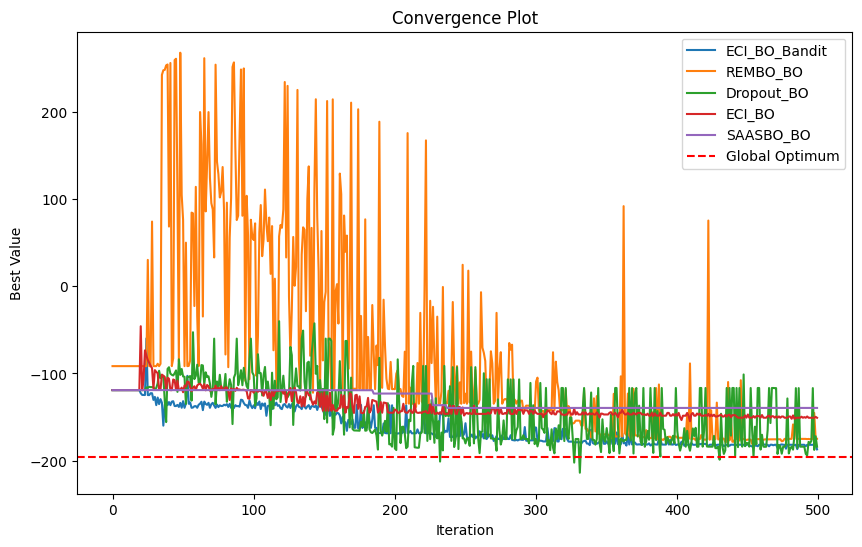

In [27]:
if __name__ == "__main__":
    # パラメータ設定
    dim = 50
    bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
    n_initial = 20
    n_iter = 500
    n_runs = 1

    # 各アルゴリズムの履歴を保持するリスト
    results = {"ECI_BO_Bandit": [], "REMBO_BO": [], "Dropout_BO": [], "ECI_BO": [], "SAASBO_BO": []}

    try:
        with tqdm.notebook.tqdm(total=n_runs, bar_format=TQDM_BAR_FORMAT) as pbar:
            with io.capture_output() as captured:
                for run in range(n_runs):
                    X_init = generate_initial_points(n_initial, dim, bounds)
                    algo1 = ECI_BO_Bandit(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        coordinate_ratio=0.8
                    )
                    algo2 = REMBO_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        d_emb=5
                    )
                    algo3 = Dropout_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        dropout_rate=0.5
                    )
                    algo4 = ECI_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim
                    )
                    algo5 = SAASBO_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim
                    )

                    best_x1, best_f1 = algo1.optimize()
                    best_x2, best_f2 = algo2.optimize()
                    best_x3, best_f3 = algo3.optimize()
                    best_x4, best_f4 = algo4.optimize()
                    best_x5, best_f5 = algo5.optimize()

                    results["ECI_BO_Bandit"].append(algo1.eval_history)
                    results["REMBO_BO"].append(algo2.eval_history)
                    results["Dropout_BO"].append(algo3.eval_history)
                    results["ECI_BO"].append(algo4.eval_history)
                    results["SAASBO_BO"].append(algo5.eval_history)

                    pbar.update(1)
    except subprocess.CalledProcessError:
        print(captured)
        raise

    plt.figure(figsize=(10,6))
    for key in results.keys():
        # 各試行の評価履歴のリスト results[key] の最小長さを求める
        min_length = min(len(hist) for hist in results[key])
        # 各履歴を最小長さに切り詰める
        data = np.array([hist[:min_length] for hist in results[key]])
        x_axis = np.arange(min_length)
        mean_history = data.mean(axis=0)
        std_history = data.std(axis=0)
        plt.plot(x_axis, mean_history, label=key)
        plt.fill_between(x_axis, mean_history - std_history, mean_history + std_history, alpha=0.3)
    global_optimum = -39.16599 * 5  # 5次元最適値
    plt.axhline(y=global_optimum, color='r', linestyle='--', label="Global Optimum")
    plt.xlabel("Iteration")
    plt.ylabel("Best Value")
    plt.title("Convergence Plot")
    plt.legend()
    plt.show()
